In [8]:
import pandas as pd
from utils.data_prep_utils import *
from transformers.encoder import *
from transformers.binner import *
from transformers.standardizer import *
from model_binclass import xgboost_binclass

In [9]:
#Data import form drive
df = pd.read_csv(r'resources/Machine failure.csv')
df = df.drop(['TWF','HDF','PWF', 'OSF', 'RNF', 'UDI', 'Product ID'], axis=1)
target_col = df.columns[-1]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  int64  
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  int64  
 6   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


In [10]:
df = data_split_stratified(df, target_col,  0.2)

encoder_info = learn_encoder(df[df.dataset==0].drop(columns=['dataset', target_col]))
df = apply_encoder(df, encoder_info, columns_to_drop=['dataset', target_col])

stand_info = learn_standardizer(df[df.dataset==0].drop(columns=['dataset', target_col]))
df = apply_standardizer(df, stand_info, columns_to_drop=['dataset', target_col])

features = df.columns.drop(target_col, 'dataset')

print(f"y_train - 0: {sum((df.dataset == 1) & (df[target_col] == 0))}, 1: {sum((df.dataset == 1) & (df[target_col] == 1))}")
print(f"y_test  - 0: {sum((df.dataset == 0) & (df[target_col] == 0))}, 1: {sum((df.dataset == 0) & (df[target_col] == 1))}")

y_train - 0: 7729, 1: 271
y_test  - 0: 1932, 1: 68


c:\Users\sulen\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:38:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Prediction Evaluation:
═══ Classification Report ═══
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9661
           1       0.98      0.92      0.95       339

    accuracy                           1.00     10000
   macro avg       0.99      0.96      0.97     10000
weighted avg       1.00      1.00      1.00     10000



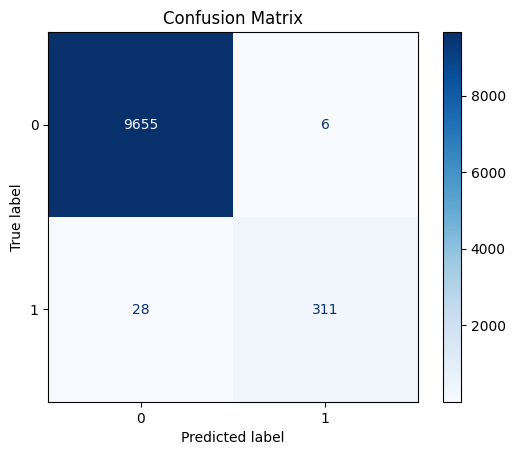


═══ Probability Metrics ═══
ROC AUC: 0.9945
Average Precision: 0.9713


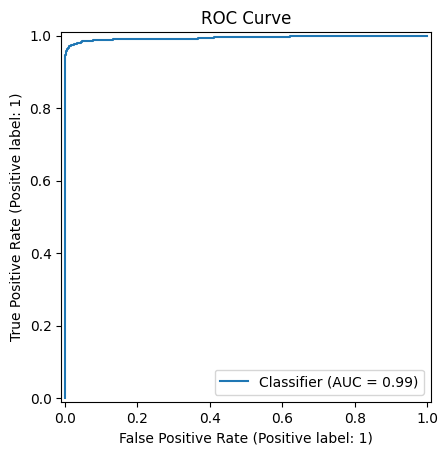

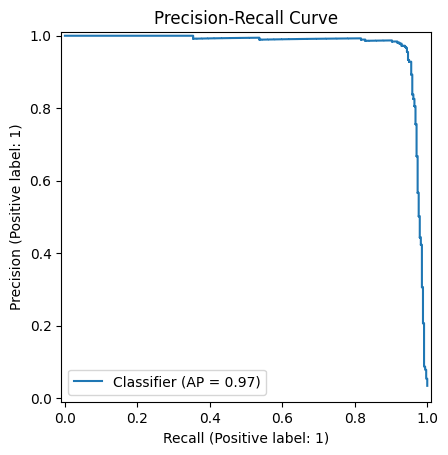

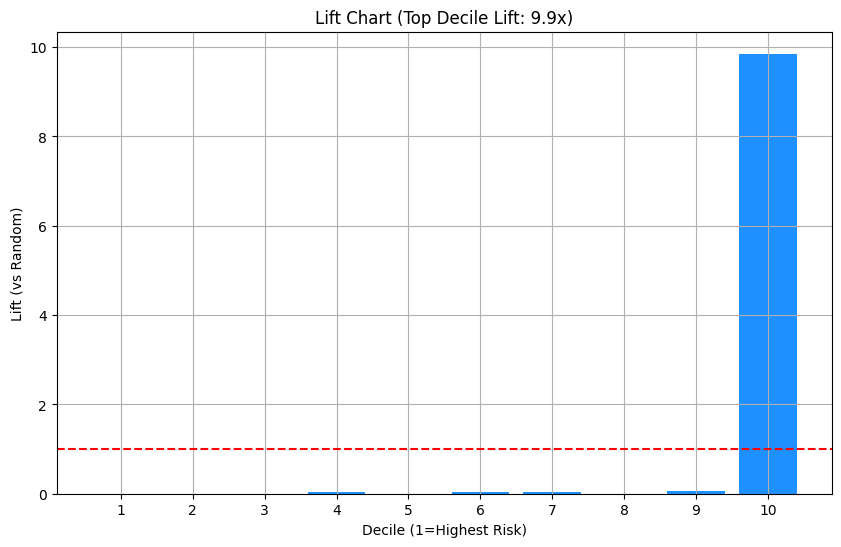

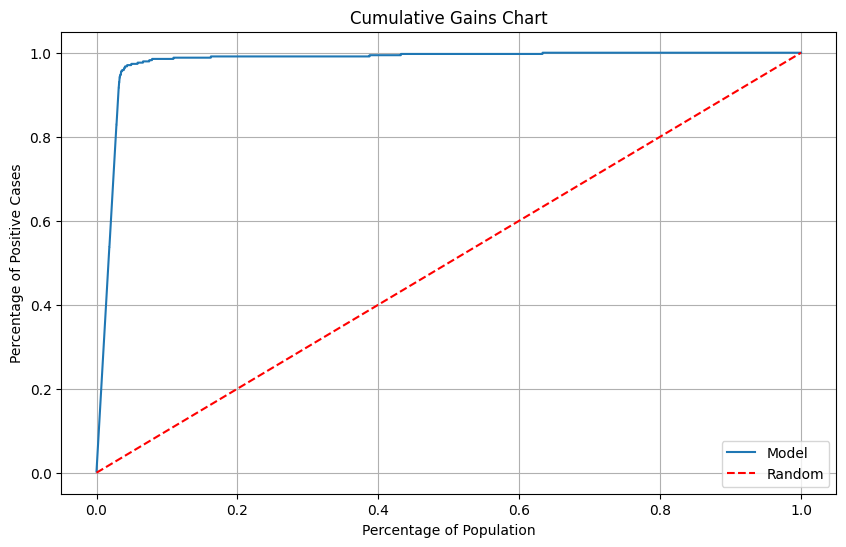

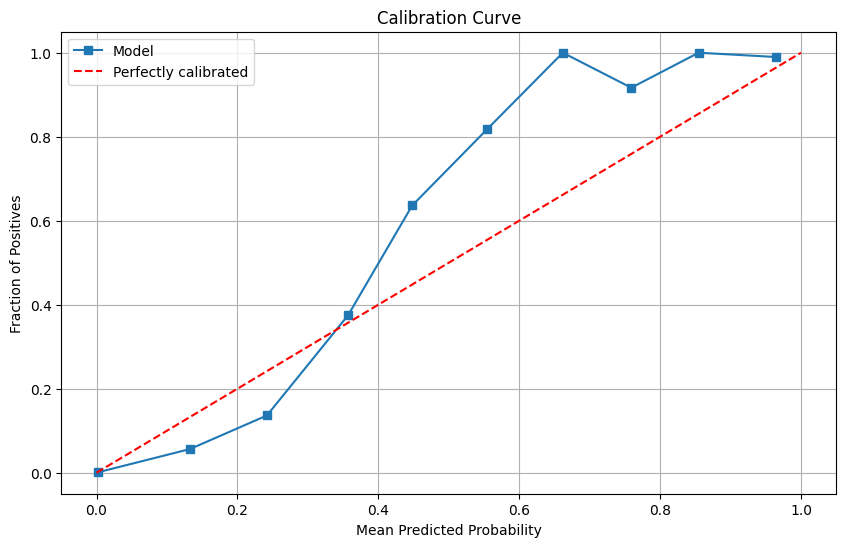

In [11]:
#XGBoost
model_info = xgboost_binclass.learn_model(df[df.dataset == 1], target_col)
df = xgboost_binclass.apply_model(df, model_info, columns=["dataset", target_col])

print("Prediction Evaluation:")
xgboost_binclass.evaluate_model(df, target_col)

In [12]:
xgboost_binclass.explain_model(model_info, df[features], index_feature = False)

XGBoostError: [01:38:59] C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (90000 vs. 80000) : 

In [13]:
save_encoder(encoder_info, filepath="resources/info/encoder_info.joblib")
save_standardizer(stand_info, filepath="resources/info/stand_info.joblib")
xgboost_binclass.save_model(model_info, filepath="resources/info/model_info.joblib")

Encoder saved to resources/info/encoder_info.joblib
Standardizer saved to resources/info/stand_info.joblib
Model saved to resources/info/model_info.joblib
